# SpaceNet PCA on MS Bands 

## Imports

In [1]:
!pip install awscli boto3 mmdet gdal
!apt-get -q install tree

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 6.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for PyYAML: filename=PyYAML-5.4.1-cp310-cp310-linux_x86_64.whl size=45658 sha256=39d4a1fa0fb61cb7ee2fbc24ba47097f515c8e53702e0df6b38aa4199a8a990c
  Stored in directory: /root/.cache/pip/wheels/c7/0d/22/696ee92245ad710f506eee79bb05c740d8abccd3ecdb778683
Successfully bui

In [87]:
COLAB = True

from google.colab import drive
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
import osgeo.gdal as gdal
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import cv2
import subprocess
import shutil
from skimage import exposure
from sklearn.linear_model import LinearRegression
import math
from google.colab.patches import cv2_imshow
import pandas as pd

if COLAB:
  from google.colab import drive
  drive.mount('/content/drive')

  ROOT_DIR_PATH = os.path.abspath('drive/MyDrive/Spatial_Finance_Transport/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [83]:
!export AWS_SHARED_CREDENTIALS_FILE=/content/drive/MyDrive/config/awscli.ini
path = "/content/drive/My Drive/config/awscli.ini"
os.environ['AWS_SHARED_CREDENTIALS_FILE'] = path
print(os.environ['AWS_SHARED_CREDENTIALS_FILE'])

/content/drive/My Drive/config/awscli.ini


## Global Variables

In [103]:
SAT_IMAGES_ROOT_PATH = ''
GSD = 0.5 # metres
TIME_LAG = 0.13 # seconds

PRED_SPEED_ROOT_PATH = os.path.join(ROOT_DIR_PATH, 'data/predicted/speed/')

SAT_IMAGES_IN_ORDER = ['blackburn_30361032', 'blackburn_30361033', 'havering_m25_5790a', 
                       'havering_m25_5790b', 'hounslow_m4_2188a', 'hounslow_m4_2188b',
                       'luton_m1_2557a', 'luton_m1_2557b', 'trafford_m60_9083a',
                       'trafford_m60_9086b']

## General Functions

In [44]:
def plot_centroid_pairs(centroids, pairs, img):
    # extract pc change img
    img = img[3,:,:]
    # Plot the image
    plt.figure(figsize=(100,100))
    plt.imshow(img, cmap='gray')
    
    # Plot the centroids
    x = [c[0] for c in centroids]
    y = [c[1] for c in centroids]
    plt.scatter(x, y, color='red')
    
    # Plot the pairs
    for pair in pairs:
        x = [pair[0][0], pair[1][0]]
        y = [pair[0][1], pair[1][1]]
        plt.plot(x, y, color='blue')
    
    # Show the plot
    plt.show()

In [97]:
def pair_centroids(centroids, threshold, time_lag=0.13):
    time_lag = time_lag * 0.000277778
    # Calculate the distance between each pair of centroids
    distances = []
    for i in range(len(centroids)):
        for j in range(i + 1, len(centroids)):
            x1, y1 = centroids[i]
            x2, y2 = centroids[j]
            distance = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
            distances.append((distance, i, j))
    
    # Sort the distances in ascending order
    distances.sort()
    
    # Pair the nearest centroids if their distance is below the threshold
    pairs = []
    paired = set()
    for distance, i, j in distances:
        if distance <= threshold and i not in paired and j not in paired:
            pairs.append((centroids[i], centroids[j]))
            paired.add(i)
            paired.add(j)

    # Calculate distance and speed for each pair
    results = []
    speeds = []
    for pair in pairs:
        x1 = pair[0][0]
        y1 = pair[0][1]
        x2 = pair[1][0]
        y2 = pair[1][1]
        distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        distance = distance * 5e-4 # convert to km 
        speed = distance / time_lag
        speeds.append(speed)
        results.append({'pair': pair, 'distance': distance, 'speed': speed})

    if len(pairs) > 0:
        avg_speed = np.median(speeds)
        avg_speed = avg_speed * 0.621371
    else:
        avg_speed = 0
    
    return pairs, avg_speed

In [8]:
def get_tif_files(directory_path):
    """
    Returns a list of all files ending in .tif in the given directory path.

    Args:
        directory_path (str): Path of the directory to search for .tif files.

    Returns:
        list: List of all files ending in .tif in the given directory path.
    """
    # Initialize an empty list to store the .tif files
    tif_files = []

    # Loop through all files in the directory
    for file in os.listdir(directory_path):
        # Check if the file ends with .tif
        if file.endswith('.tif'):
            # Append the file path to the list
            tif_files.append(os.path.join(directory_path, file))

    # Return the list of .tif files
    return tif_files

In [9]:
def tif_to_array(tif_path):
    ds = gdal.Open(tif_path)
    array = np.array([ds.GetRasterBand(i).ReadAsArray() for i in range(1, ds.RasterCount + 1)])
    array = array.transpose((1,2,0))

    print("array shape: {}".format(array.shape))
    return array

In [10]:
def apply_pca_to_wv2_image(ms_img, n_components=5):
    """
    Apply PCA to resampled multispectral bands of WV2 images for change detection.
    
    Args:
        ms_img (ndarray): Multispectral image (MS) of WV2.
        n_components (int): Number of PCA components to retain (default: 5).
    
    Returns:
        ndarray: Reconstructed images using the first n_components of PCA.
    """
    # Normalize the pixel values
    images = ms_img.astype(float)
    images /= 255.0  # assuming pixel values range from 0 to 255

    # Transpose the array to change the shape
    images = np.transpose(images, (2, 0, 1))

    print("images shape after stacking: {}".format(images.shape))
    n_samples, width, height = images.shape
    
    # Reshape the images to a 2D array
    X = np.reshape(images, (n_samples, -1))
    print("X shape: {}".format(X.shape))

    # Standardize the data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Apply PCA with n_components
    pca = PCA(n_components=n_components)
    pca.fit(X)
    
    # Reconstruct the images using the first n_components of PCA
    pc1_to_pcN = pca.components_[:n_components]
    reconstructed_images = np.dot(pca.transform(X)[:,:n_components], pc1_to_pcN) + pca.mean_
    reconstructed_images = np.reshape(reconstructed_images, (n_samples, width, height))
    print("reconstructed images shape: {}".format(reconstructed_images.shape))
    
    """
    fig, axs = plt.subplots(n_components, 1, figsize=(100, 100))
    
    for i in range(n_components):
        axs[i].imshow(reconstructed_images[i, :, :], cmap='gray')
        axs[i].set_title('PC{} - Channel {}'.format(i+1, i+1))
        axs[i].axis('off')
    """
    fig, ax = plt.subplots(figsize=(100, 100))
    ax.imshow(reconstructed_images[3, :, :], cmap='gray')
    ax.set_title('PC{} - Channel {}'.format(4, 1))
    ax.axis('off')

    plt.tight_layout()
    plt.show()

    
    return reconstructed_images

In [11]:
def show_image_mul(mul_img, ms1=False, ms2=False):
    fig, ax = plt.subplots(figsize=(16, 16))

    # Normalize DN values to [0, 1] for each band
    mul_img = (mul_img - np.min(mul_img, axis=(0, 1), keepdims=True)) / (np.max(mul_img, axis=(0, 1), keepdims=True) - np.min(mul_img, axis=(0, 1), keepdims=True))

    if ms1:
        print("Printing image with ms1 bands")
        ax.imshow(mul_img[:, :, :3])  # show the first 3 channels (RGBNIR1)
        ax.set_title("Image with MS1 bands")
        ax.axis('off')
    elif ms2:
        print("Printing image with ms2 bands")
        ax.imshow(mul_img[:, :, 5:8])  # show the last 3 channels (RedEdge, Yellow, Coastal, NIR2)
        ax.set_title("Image with MS2 bands")
        ax.axis('off')
    else:
        print("Printing image with all bands")
        ax.imshow(mul_img[:, :, :])  # show all bands
        ax.set_title("Image with all bands")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [12]:
def extract_vehicle_centroids(pc_change_image, channel_index=3, aspect_ratio_threshold=0.001, rectangularity_threshold=0.001, area_threshold=50):
 """
 Extract centroids of moving vehicles from PCA change image based on morphological features.

 Args:
 pc_change_image (ndarray): PCA change image.
 channel_index (int): Index of the channel to use for processing (default: 0).
 aspect_ratio_threshold (float): Threshold for aspect ratio (default: 0.5).
 rectangularity_threshold (float): Threshold for rectangularity (default: 0.5).
 area_threshold (int): Threshold for area (default: 100).

 Returns:
 ndarray: Centroids of moving vehicles.
 """
 # Extract the specific channel for processing
 pc_change_image = pc_change_image[3, :, :]

 # Convert PCA change image to binary image based on thresholding
 _, binary_image = cv2.threshold(pc_change_image.astype(np.uint8), 0, 255, cv2.THRESH_BINARY)

 # Find contours in the binary image
 contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

 # Initialize list to store centroids
 centroids = []

 # Loop through contours and extract centroids of objects based on morphological features
 for contour in contours:
  # Fit minimum area bounding rectangle to contour
  rect = cv2.minAreaRect(contour)
  box = cv2.boxPoints(rect)
  box = np.int0(box)

  # Calculate width and height of bounding rectangle
  width = rect[1][0]
  height = rect[1][1]

  # Calculate aspect ratio and rectangularity of contour
  aspect_ratio = max(width, height) / min(width, height) if min(width, height) > 0 else 0
  rectangularity = cv2.contourArea(contour) / (width * height) if width * height > 0 else 0

  # Check if aspect ratio and rectangularity meet threshold criteria
  if aspect_ratio >= aspect_ratio_threshold and rectangularity >= rectangularity_threshold:
    # Extract centroid of contour and add to list
    M = cv2.moments(contour)
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    centroids.append((cX, cY))

 # Convert centroids to numpy array and return
 centroids = np.array(centroids)

 # Plot the centroids on the pc_change_image
 fig, ax = plt.subplots(figsize=(100,100))
 ax.imshow(pc_change_image, cmap='gray')
 ax.scatter(centroids[:, 0], centroids[:, 1], s=100, c='red')
 plt.show()
 return centroids

In [13]:
def copy_files(source_dir, dest_dir):
    """
    Copy all files from source_dir to dest_dir (ignoring directories).
    """
    # Create destination directory if it doesn't exist
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)
    
    # Copy each file in source directory to destination directory
    for file_name in os.listdir(source_dir):
        source_file = os.path.join(source_dir, file_name)
        dest_file = os.path.join(dest_dir, file_name)
        print("copying {}".format(source_file))
        if os.path.isfile(source_file):
            shutil.copy2(source_file, dest_file)

In [14]:
def normalize_images(imgs):
    """Normalize image pixel values to [0, 1] range."""
    imgs = (imgs - np.min(imgs, axis=(1, 2, 3), keepdims=True)) / (np.max(imgs, axis=(1, 2, 3), keepdims=True) - np.min(imgs, axis=(1, 2, 3), keepdims=True))

    return imgs

## Data

### Get Data from Drive

In [15]:
%mkdir /content/images

In [16]:
parent_dirs = ["/content/drive/MyDrive/Spatial_Finance_Transport/data/satellite_images/"]
target_dirs = ['/content/images']

for parent_dir, target_dir in zip(parent_dirs, target_dirs):
  copy_files(parent_dir, target_dir)

copying /content/drive/MyDrive/Spatial_Finance_Transport/data/satellite_images/processed
copying /content/drive/MyDrive/Spatial_Finance_Transport/data/satellite_images/blackburn_30361032.tif
copying /content/drive/MyDrive/Spatial_Finance_Transport/data/satellite_images/blackburn_30361033.tif
copying /content/drive/MyDrive/Spatial_Finance_Transport/data/satellite_images/havering_m25_5790a.tif
copying /content/drive/MyDrive/Spatial_Finance_Transport/data/satellite_images/havering_m25_5790b.tif
copying /content/drive/MyDrive/Spatial_Finance_Transport/data/satellite_images/hounslow_m4_2188a.tif
copying /content/drive/MyDrive/Spatial_Finance_Transport/data/satellite_images/hounslow_m4_2188b.tif
copying /content/drive/MyDrive/Spatial_Finance_Transport/data/satellite_images/trafford_m60_9083a.tif
copying /content/drive/MyDrive/Spatial_Finance_Transport/data/satellite_images/trafford_m60_9086b.tif
copying /content/drive/MyDrive/Spatial_Finance_Transport/data/satellite_images/luton_m1_2557a.tif

### Check Tree Structure

In [17]:
!tree images

images
├── blackburn_30361032.tif
├── blackburn_30361033.tif
├── havering_m25_5790a.tif
├── havering_m25_5790b.tif
├── hounslow_m4_2188a.tif
├── hounslow_m4_2188b.tif
├── luton_m1_2557a.tif
├── luton_m1_2557b.tif
├── trafford_m60_9083a.tif
└── trafford_m60_9086b.tif

0 directories, 10 files


## One Satellite Image Example

In [18]:
file_path = '/content/images/havering_m25_5790a.tif'

ms_img = tif_to_array(file_path)

array shape: (4602, 1146, 8)


### Visualise Image

Printing image with ms1 bands


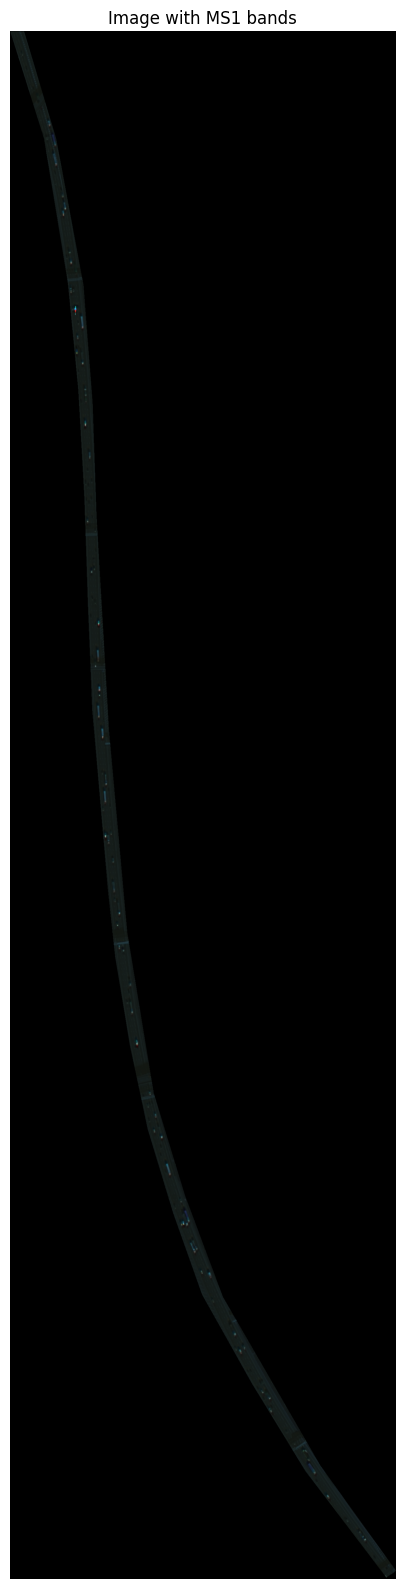

In [19]:
show_image_mul(ms_img, ms1=True, ms2=False)

### PCA

images shape after stacking: (8, 4602, 1146)
X shape: (8, 5273892)
reconstructed images shape: (8, 4602, 1146)


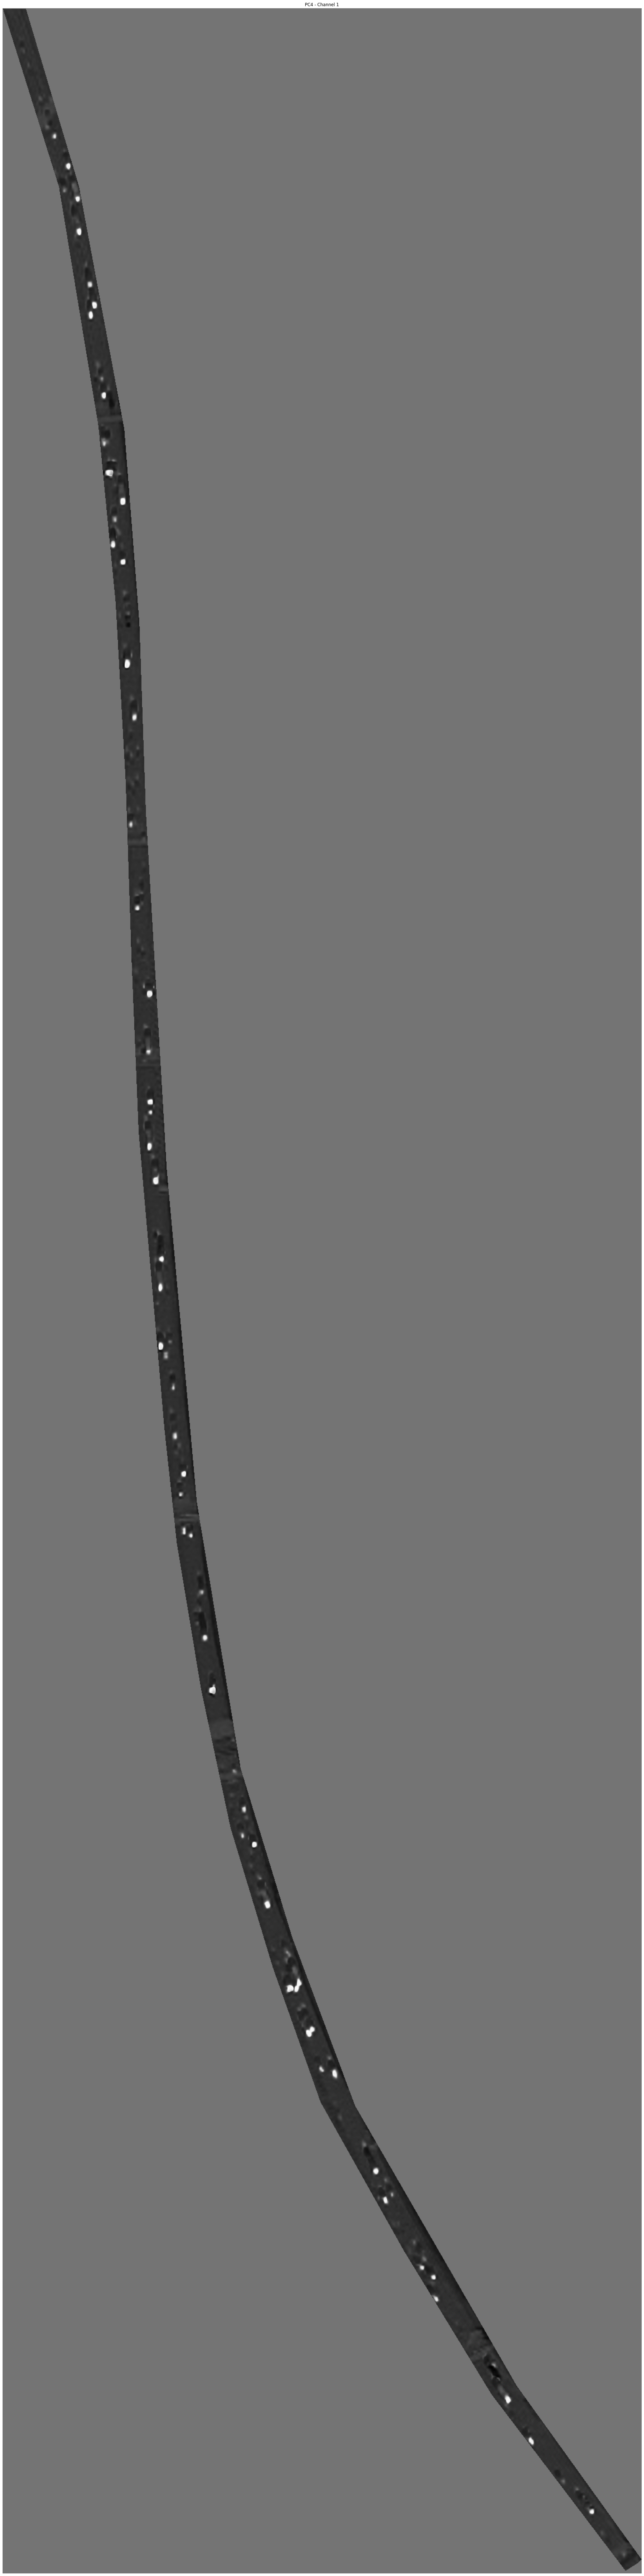

In [20]:
recon_imgs = apply_pca_to_wv2_image(ms_img, n_components=4)

### Vehicle Object Extraction

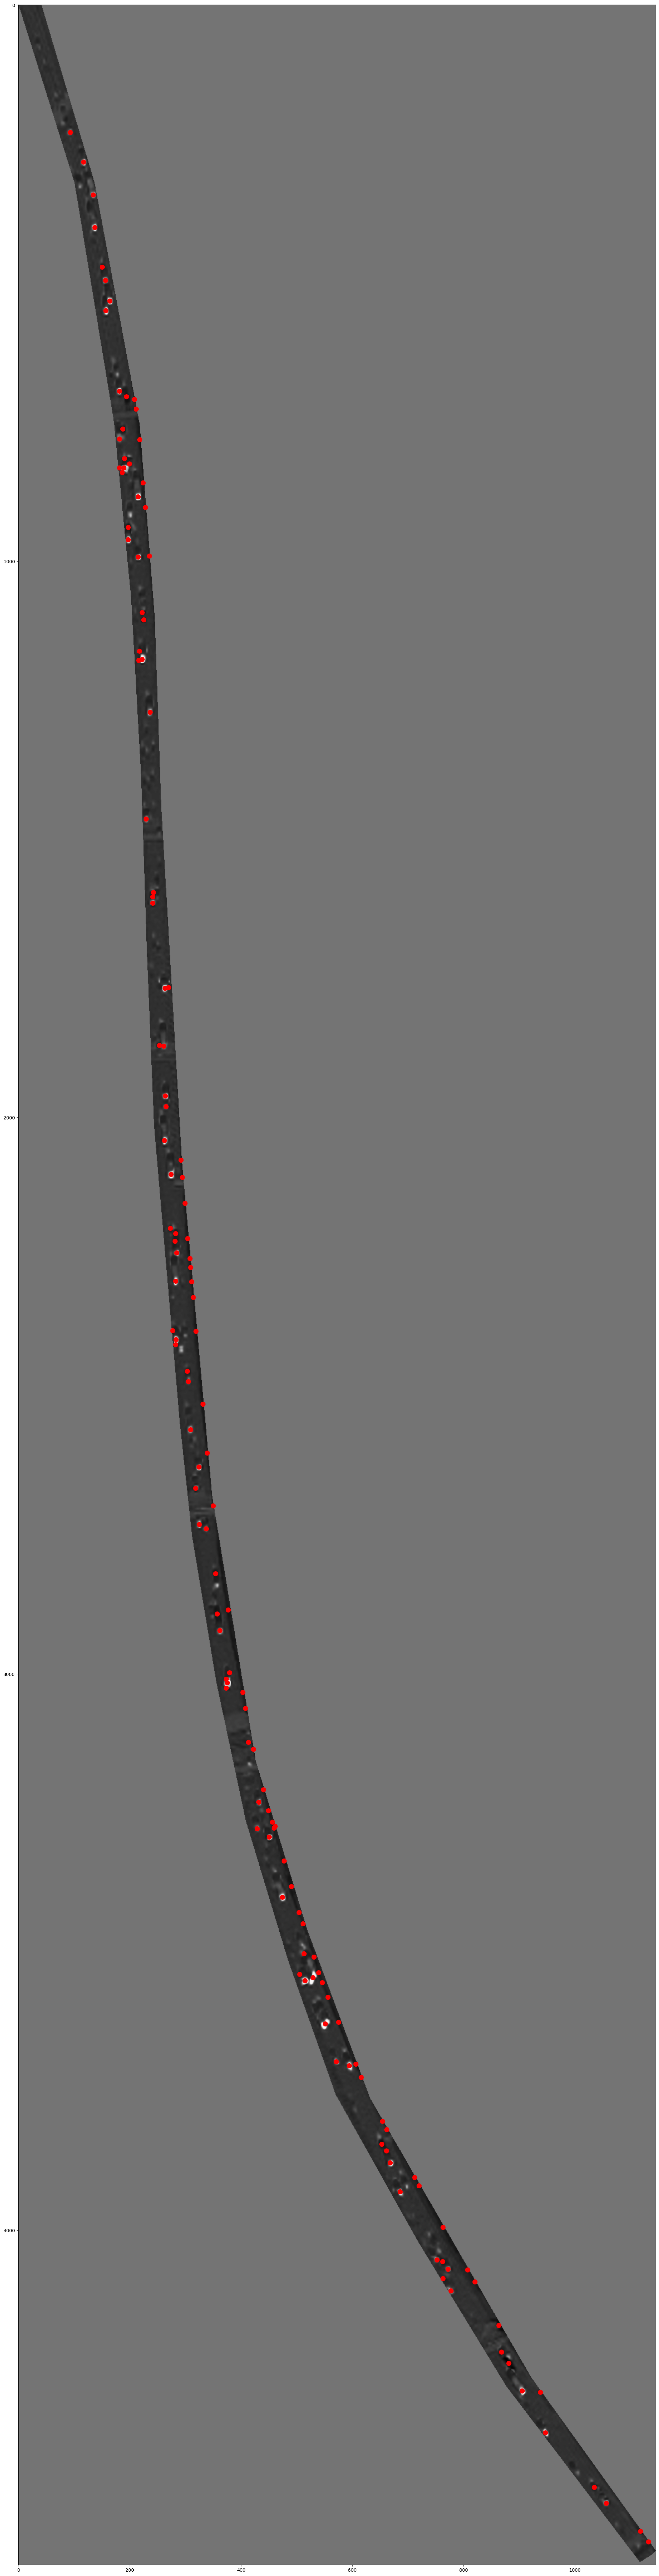

In [22]:
centroids = extract_vehicle_centroids(recon_imgs)

In [68]:
result_pair_centroids, avg_speed = pair_centroids(centroids, threshold=10)

print(result_pair_centroids)
print(avg_speed)

[(array([ 459, 3277]), array([ 461, 3274])), (array([ 216, 1178]), array([ 222, 1176])), (array([ 270, 1766]), array([ 263, 1767])), (array([ 375, 3016]), array([ 373, 3009])), (array([189, 832]), array([181, 832])), (array([ 261, 1871]), array([ 253, 1870])), (array([ 241, 1603]), array([ 242, 1595])), (array([ 282, 2408]), array([ 283, 2399]))]
99.45197128171745


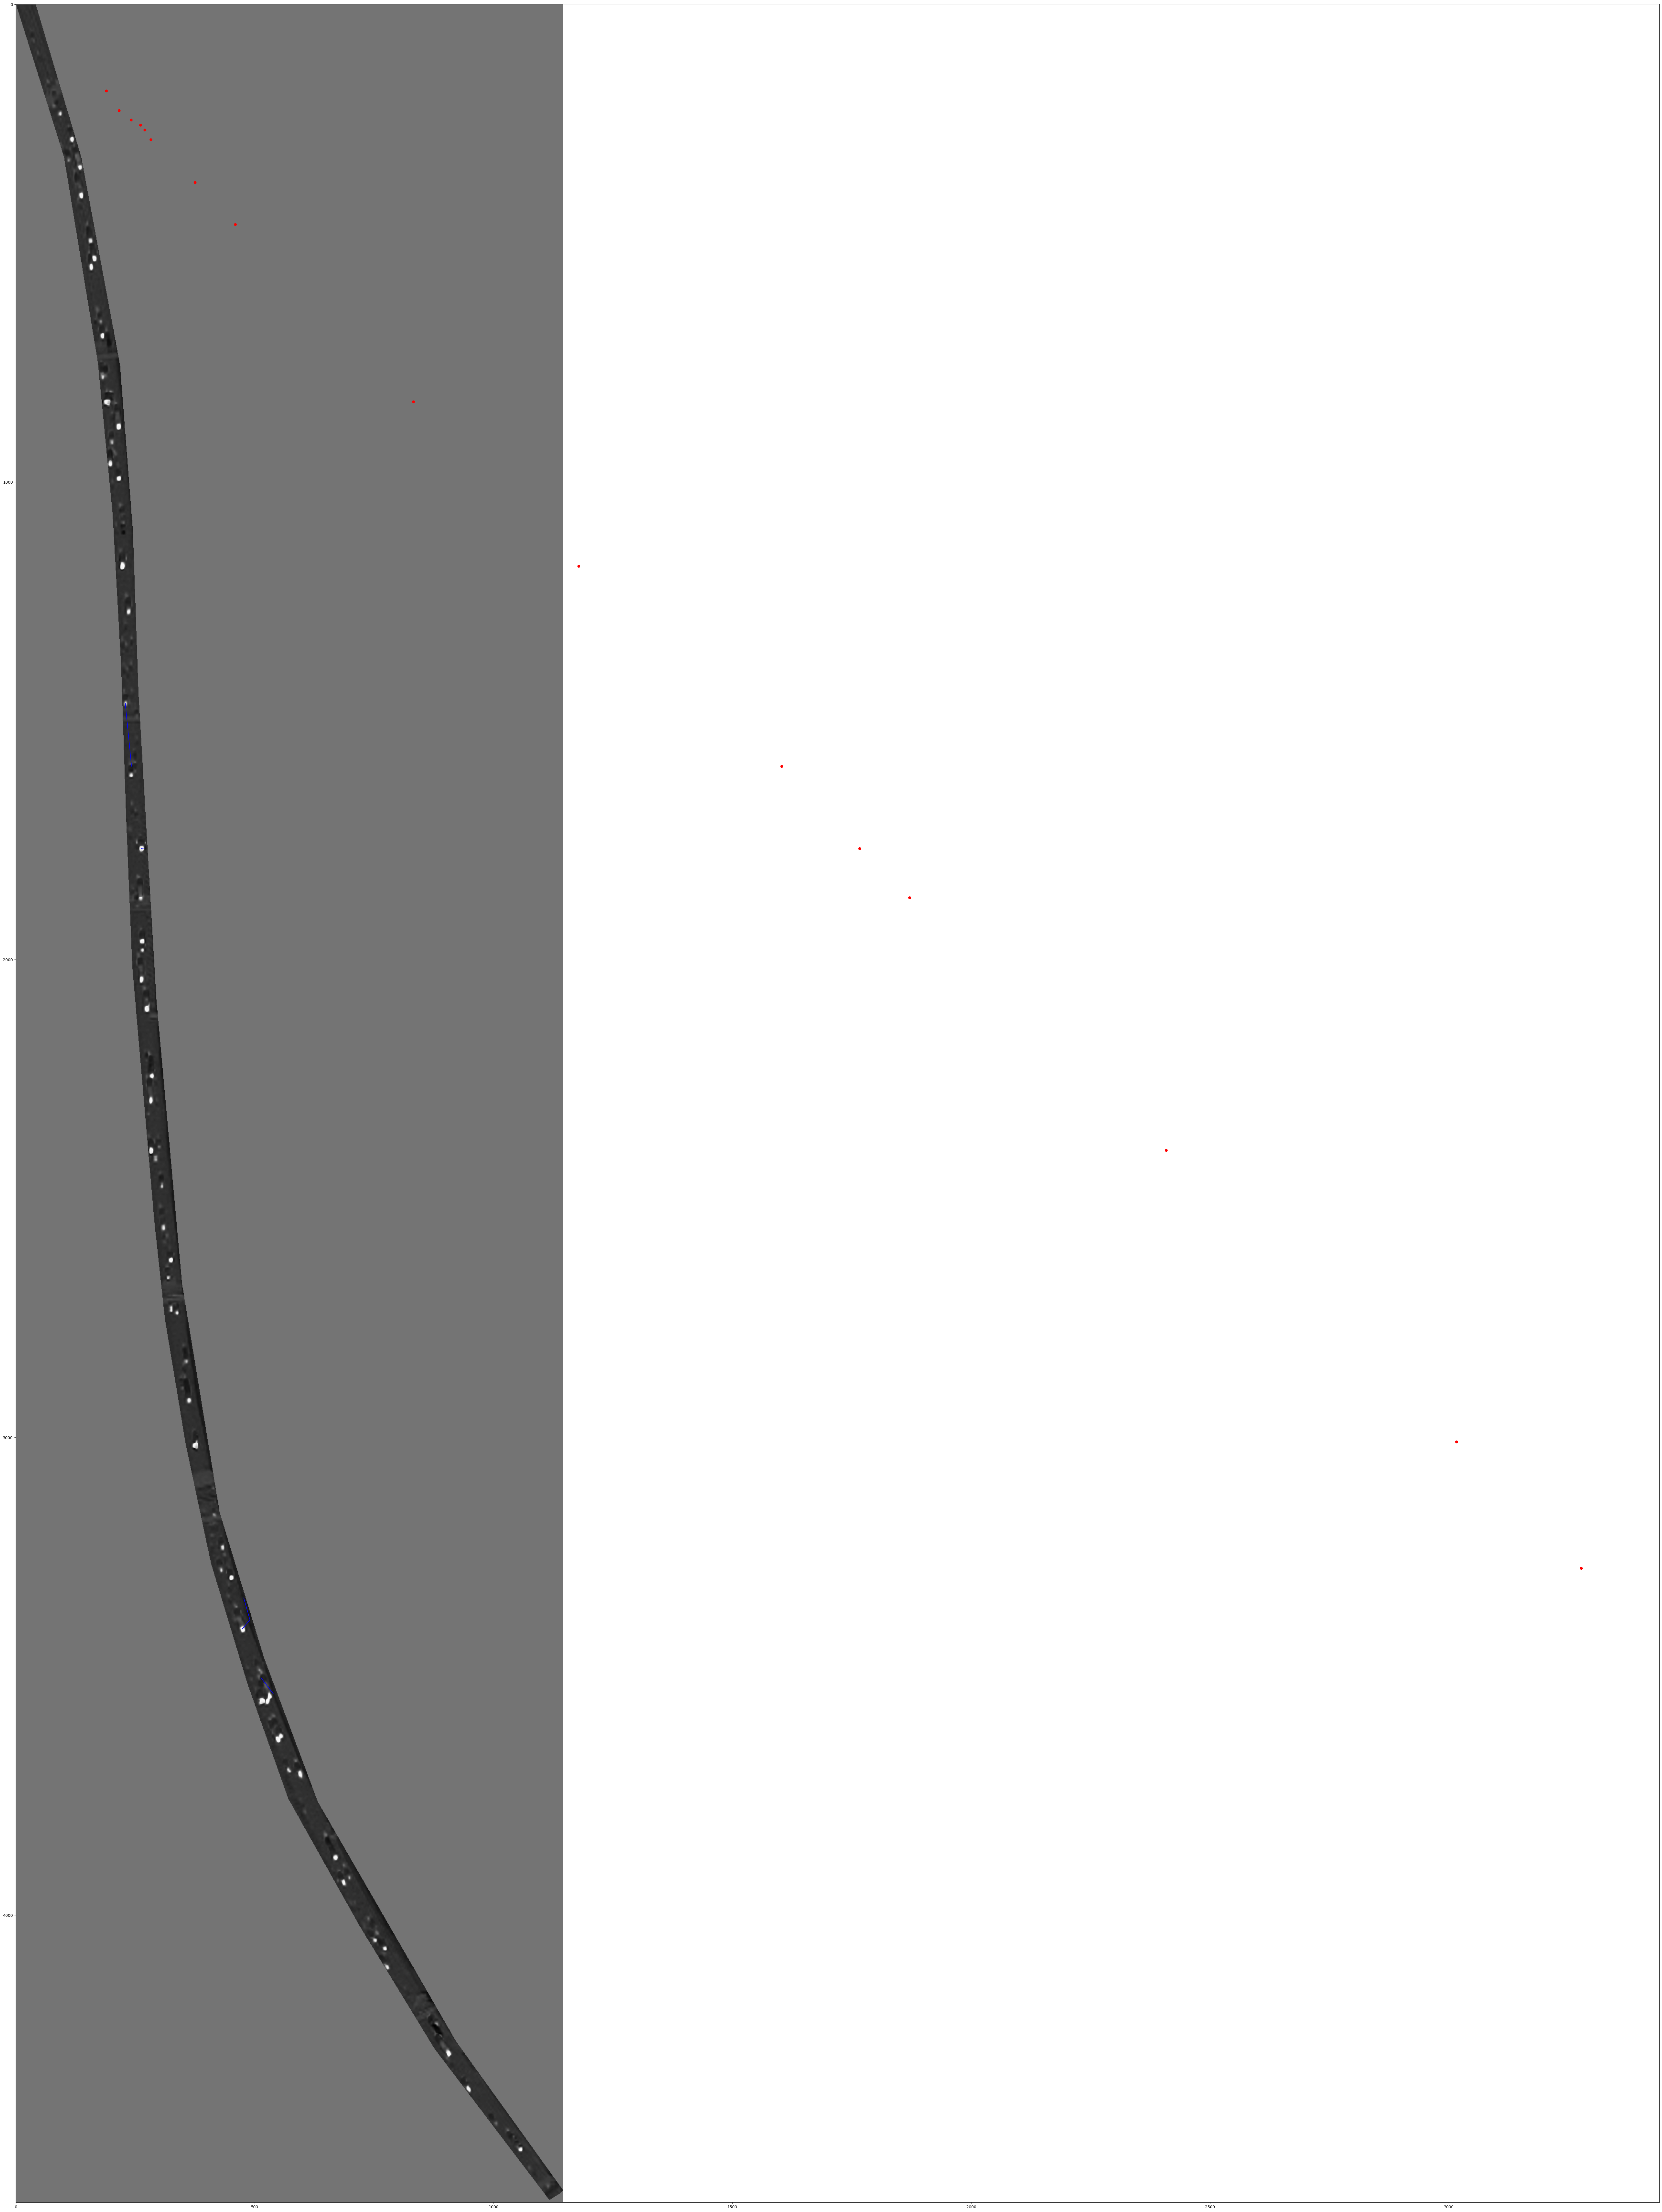

In [54]:
plot_centroid_pairs(centroids, result_pair_centroids, recon_imgs)

## All Satellite Images

### Load Images

array shape: (1120, 2418, 8)
array shape: (1133, 2474, 8)
array shape: (4602, 1146, 8)
array shape: (4350, 1067, 8)
array shape: (1525, 3776, 8)
array shape: (1506, 3745, 8)
array shape: (1518, 1717, 8)
array shape: (1479, 1699, 8)
array shape: (2864, 1745, 8)
array shape: (2846, 1741, 8)
Printing image with ms1 bands


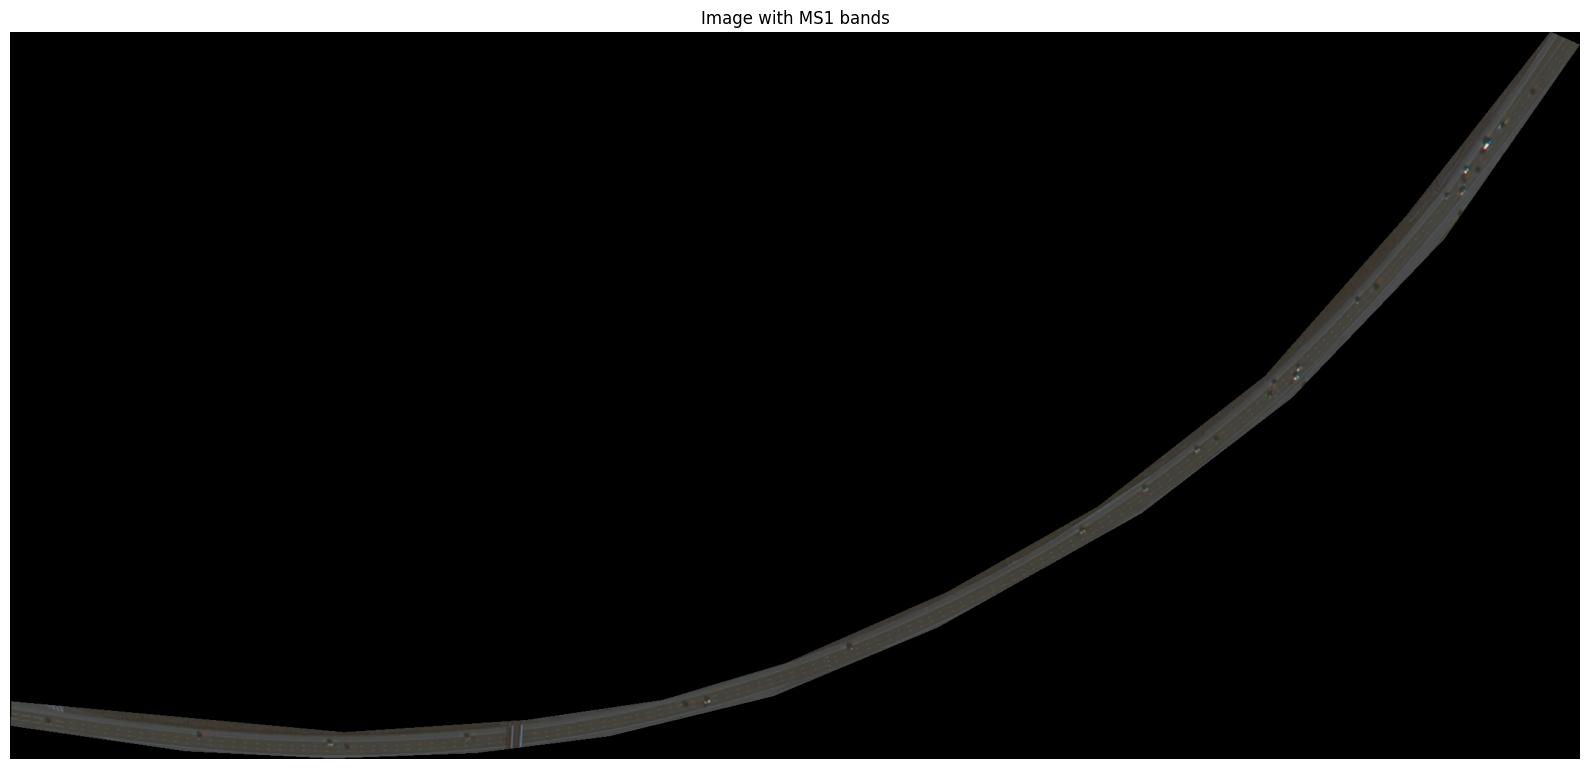

In [70]:
ms_image_paths = get_tif_files("/content/drive/MyDrive/Spatial_Finance_Transport/data/satellite_images/")

ms_images_list = []

for ms_image_path in ms_image_paths:
  ms_img = tif_to_array(ms_image_path)

  ms_images_list.append(ms_img)

show_image_mul(ms_images_list[0], ms1=True, ms2=False)

### PCA

In [71]:
recon_imgs_list = []

for ms_img in ms_images_list:
  recon_imgs = apply_pca_to_wv2_image(ms_img, n_components=4)

  recon_imgs_list.append(recon_imgs)

Output hidden; open in https://colab.research.google.com to view.

### Vehicle Object Extraction

In [72]:
vehicle_centroid_list = []

for recon_img in recon_imgs_list:

  centroids = extract_vehicle_centroids(recon_img)

  vehicle_centroid_list.append(centroids)

Output hidden; open in https://colab.research.google.com to view.

### Speeds

In [101]:
results_list = []
avg_speeds_list = []

for centroids, recon_img in zip(vehicle_centroid_list, recon_imgs_list):

  results, avg_speed = pair_centroids(centroids, threshold=10, time_lag=0.13)

  results_list.append(results)

  avg_speeds_list.append(avg_speed)

print(results_list[0])
print(avg_speeds_list)

[(array([2144,  310]), array([2150,  304])), (array([ 361, 1069]), array([ 352, 1068])), (array([ 458, 1081]), array([ 452, 1074]))]
[77.90883531604908, 0, 65.73191238224634, 86.03591578665197, 0, 65.52300135863563, 0, 61.61882411012799, 86.03591578665197, 67.19619833890309]


In [105]:
# saving data
df_avg_speed = pd.DataFrame(columns=['image_id', 'avg_speed_estimate'])

for sat_img, avg_speed in zip(SAT_IMAGES_IN_ORDER, avg_speeds_list):
  df_avg_speed = df_avg_speed.append({'image_id': sat_img, 'avg_speed_estimate': avg_speed}, ignore_index=True)

df_avg_speed.to_csv(PRED_SPEED_ROOT_PATH+'avg_speed_estimates.csv')

df_avg_speed

<ipython-input-105-868fff64fe1d>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_avg_speed = df_avg_speed.append({'image_id': sat_img, 'avg_speed_estimate': avg_speed}, ignore_index=True)
<ipython-input-105-868fff64fe1d>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_avg_speed = df_avg_speed.append({'image_id': sat_img, 'avg_speed_estimate': avg_speed}, ignore_index=True)
<ipython-input-105-868fff64fe1d>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_avg_speed = df_avg_speed.append({'image_id': sat_img, 'avg_speed_estimate': avg_speed}, ignore_index=True)
<ipython-input-105-868fff64fe1d>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.conc

,image_id,avg_speed_estimate
0,blackburn_30361032,77.908835
1,blackburn_30361033,0.000000
2,havering_m25_5790a,65.731912
3,havering_m25_5790b,86.035916
4,hounslow_m4_2188a,0.000000
5,hounslow_m4_2188b,65.523001
6,luton_m1_2557a,0.000000
7,luton_m1_2557b,61.618824
8,trafford_m60_9083a,86.035916
9,trafford_m60_9086b,67.196198


In [80]:
for centroids, recon_img, results in zip(vehicle_centroid_list, recon_imgs_list, results_list):

  plot_centroid_pairs(centroids, results, recon_img)

Output hidden; open in https://colab.research.google.com to view.